In [1]:
import re

def clean_text(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation (but keep spaces)
    text = re.sub(r'\s+', ' ', text).strip()    # Normalize multiple spaces to one
    return text



In [2]:
import pandas as pd

real = pd.read_csv("../data/raw/True.csv")
fake = pd.read_csv("../data/raw/Fake.csv")

real['label'] = "REAL"
fake["label"] = "FAKE"

# print(real.isnull().sum())
# print(fake.isnull().sum())

In [3]:
cols = ['id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']

train = pd.read_csv("../data/raw/train.tsv",sep="\t",header=None,names=cols)
test = pd.read_csv("../data/raw/test.tsv",sep="\t",header=None,names=cols)
valid = pd.read_csv("../data/raw/valid.tsv",sep="\t",header=None,names=cols)

liar = pd.concat([train,test,valid]).reset_index(drop=True)

fake_labels = ['pants-fire', 'false', 'barely-true']
real_labels = ['half-true', 'mostly-true', 'true']

liar['label'] = liar['label'].apply(lambda x: 'FAKE' if x in fake_labels else 'REAL')

liar['text'] = liar['statement'].apply(clean_text)
liar = liar[['text','label']]


# Save
liar.to_csv("../data/processed/liar_clean.csv", index=False)

In [4]:
print(liar.isnull().sum())

text     0
label    0
dtype: int64


In [5]:
#welFake
welfake = pd.read_csv("../data/raw/WELFake_Dataset.csv")

# print(welfake.columns.tolist())

# welfake = welfake.rename(columns={'text_column_name':'text','label_column_name':'label'})
welfake['label'] = welfake['label'].map({1:'REAL',0:'FAKE'})

welfake = welfake.sample(50000,random_state=42)

welfake['text'] = welfake['text'].apply(clean_text)
welfake = welfake[['text','label']]

welfake.to_csv("../data/processed/welfake_clean.csv.gz")

In [6]:
welfake.to_csv("../data/processed/welfake_clean.csv")


In [7]:
print(welfake.isnull().sum())

text     0
label    0
dtype: int64


In [8]:
fever = pd.read_json("../data/raw/FEVER.jsonl",lines=True)

fever = fever[fever['label'].isin (['SUPPORTS',"REFUTES"])]

fever['label'] = fever['label'].map({
    'SUPPORTS':"REAL",
    'REFUTES':"FAKE"
})

fever = fever[['claim','label']]
fever = fever.rename(columns={'claim':'text'})
fever = fever.dropna(subset=['text','label'])

print(fever.shape)

(109810, 2)


In [9]:
indian = pd.read_csv('../data/raw/indian.csv')

indian = indian[['text','label']]
indian = indian.dropna(subset=['label','text'])


In [10]:
indian.isnull().sum()

text     0
label    0
dtype: int64

In [11]:
df = pd.concat([real,fake,liar,welfake,fever,indian]).reset_index(drop=True)
if 'title' in df.columns:
    df['text'] = (df['title'].fillna('')+" "+df['text'].fillna(''))
else:
    df['text'] = df['text'].fillna('')

df['text'] = (df['title']+" "+df["text"]).apply(clean_text)
df = df[["text","label"]]

df.to_csv("../data/processed/merged_clean_dataset.csv")

In [12]:
df['label'].value_counts()

label
REAL    136105
FAKE     85115
Name: count, dtype: int64

In [13]:
df.to_csv("../data/processed/merged_clean_dataset.csv.gz")

In [14]:
merged = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
merged.info()
merged['label'].value_counts()
# merged.dropna()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221220 entries, 0 to 221219
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    221220 non-null  object
 1   label   221220 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB


label
REAL    136105
FAKE     85115
Name: count, dtype: int64

In [16]:
merged.isnull().sum()

text     0
label    0
dtype: int64

In [17]:
merged.dropna(subset=['text'],inplace=True)

In [18]:
merged.to_csv("../data/processed/merged_clean_dataset.csv")
merged.to_csv("../data/processed/merged_clean_dataset.csv.gz")


### Balancing Label Distribution

In [19]:
from sklearn.utils import resample

real_df = df[df['label']=='REAL']
fake_df = df[df['label']=='FAKE']

real_downsampled = resample(real_df, replace=False,
                            n_samples=len(fake_df),
                            random_state=42
                            )

balanced_df = pd.concat([real_downsampled,fake_df]).sample(frac=1, random_state = 42)



In [20]:
balanced_df['label'].value_counts()

label
FAKE    85115
REAL    85115
Name: count, dtype: int64

In [21]:
balanced_df.to_csv('../data/processed/balanced_df.csv',index=False)
# balanced_df.to_csv('../data/processed/balanced_df.csv.gz',index=False,compression='gzip')


### Now We'll do some EDA on these preprocessed data

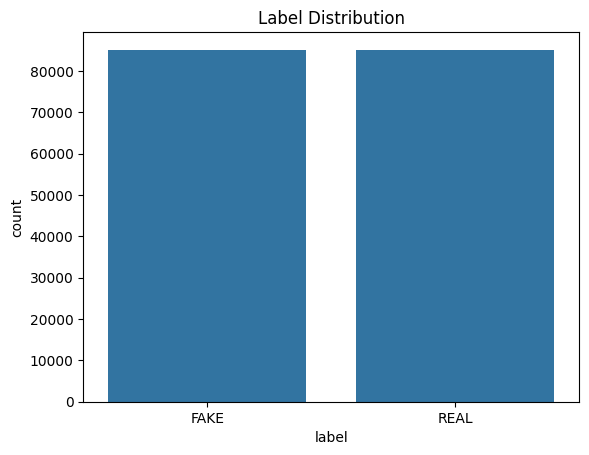

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

df = pd.read_csv('../data/processed/balanced_df.csv')

sns.countplot(x='label',data=df)
plt.title("Label Distribution")
plt.show()

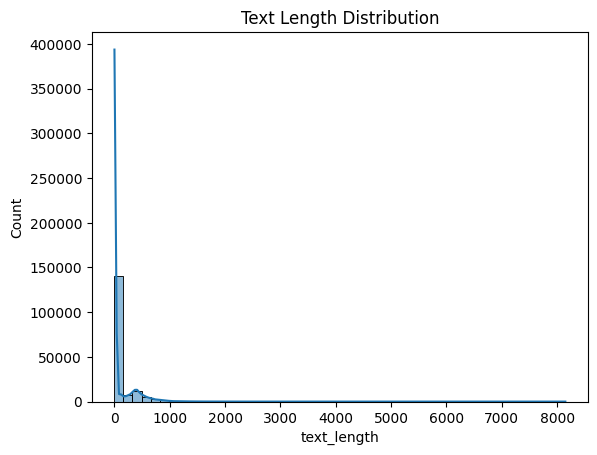

In [23]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
sns.histplot(df['text_length'],bins=50, kde=True)
plt.title("Text Length Distribution")
plt.show()

Top words in REAL: [('the', 297944), ('to', 160582), ('of', 130318), ('a', 122551), ('in', 116872), ('and', 112507), ('on', 70794), ('said', 60930), ('that', 53660), ('for', 52493), ('with', 35216), ('is', 34537), ('he', 33575), ('trump', 32495), ('as', 30530), ('us', 30222), ('by', 30211), ('was', 30021), ('it', 28980), ('has', 28930)]
Top words in FAKE: [('the', 539072), ('to', 308515), ('of', 246028), ('and', 231309), ('a', 217501), ('in', 173542), ('that', 151841), ('s', 129461), ('is', 116288), ('for', 101548), ('on', 88454), ('trump', 87856), ('it', 80492), ('he', 79515), ('was', 69402), ('with', 67805), ('his', 61268), ('as', 57726), ('this', 57335), ('be', 50393)]


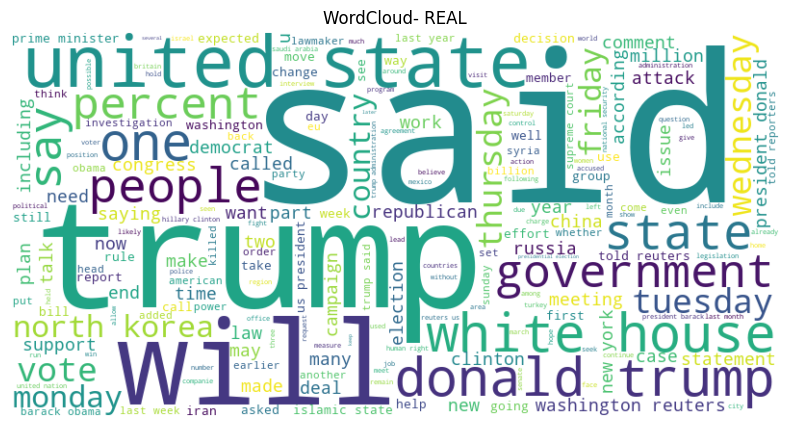

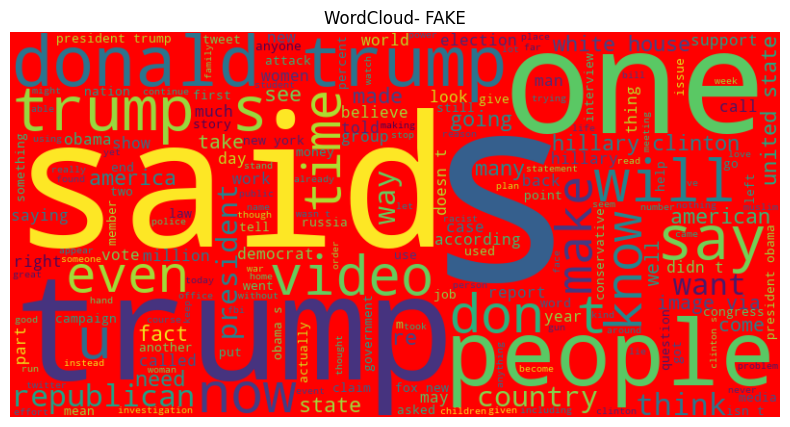

In [24]:
def get_top_words(texts, n=20):
    texts = texts.dropna().astype(str)
    all_words = ' '.join(texts).split()
    return Counter(all_words).most_common(n)
print("Top words in REAL:",get_top_words(df[df['label']=='REAL']['text']))
print("Top words in FAKE:",get_top_words(df[df['label']=='FAKE']['text']))

real_text = ' '.join(df[df['label']=='REAL']['text'].dropna().astype(str))
fake_text = ' '.join(df[df['label']=='FAKE']['text'].dropna().astype(str))

wc_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)
wc_fake = WordCloud(width=800, height=400, background_color='red').generate(fake_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud- REAL")
plt.show()


plt.figure(figsize=(10,5))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud- FAKE")
plt.show()


SOME MORE EDA


In [25]:
from nltk.corpus import stopwords
from collections import Counter
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kknah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

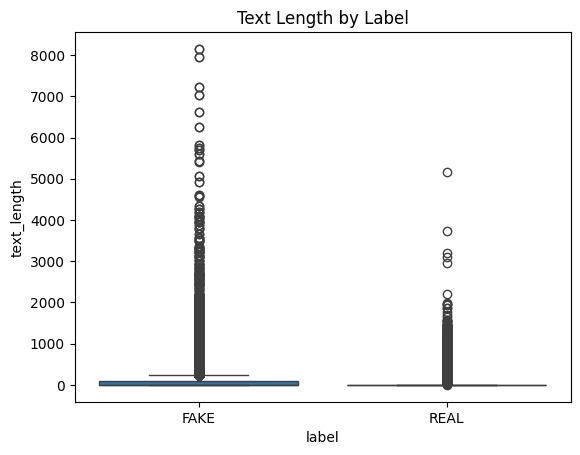

label
FAKE    125.365623
REAL     63.411913
Name: text_length, dtype: float64


In [27]:
df = pd.read_csv('../data/processed/balanced_df.csv')

df['text_length'] = df['text'].astype(str).apply(lambda x: len(x.split()))

sns.boxplot(x='label',y='text_length',data=df)
plt.title("Text Length by Label")
plt.show()

print(df.groupby('label')['text_length'].mean())

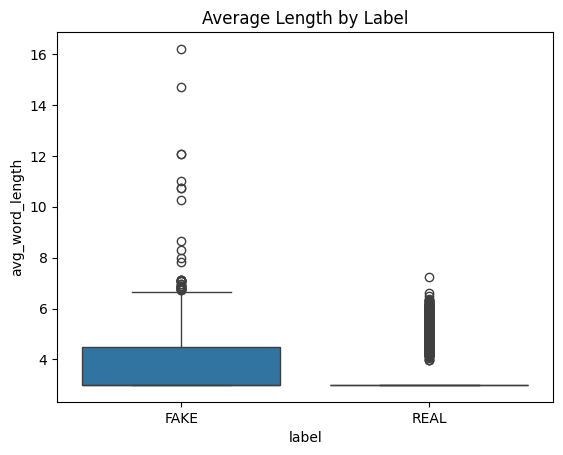

label
FAKE    3.519769
REAL    3.324003
Name: avg_word_length, dtype: float64


In [29]:
df['avg_word_length'] = df['text'].astype(str).apply(
    lambda x: sum(len(word) for word in x.split())/len(x.split())
)

sns.boxplot(x='label',y='avg_word_length',data=df)
plt.title("Average Length by Label")
plt.show()

print(df.groupby('label')['avg_word_length'].mean())

In [34]:
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    words = ' '.join(texts.dropna().astype(str)).lower().split()
    words = [w for w in words if w not in stop_words and w.isalpha()]
    return Counter(words).most_common(n)

print("Top 20 REAL words:", get_top_words(df[df['label'] == 'REAL']['text']))
print("Top 20 FAKE words:", get_top_words(df[df['label'] == 'FAKE']['text']))


Top 20 REAL words: [('said', 60930), ('trump', 32495), ('us', 30222), ('would', 19430), ('reuters', 17660), ('president', 16305), ('state', 12177), ('house', 11893), ('government', 11515), ('new', 11330), ('states', 11038), ('republican', 10123), ('also', 9762), ('united', 9657), ('people', 9303), ('told', 8827), ('could', 8603), ('trumps', 8168), ('one', 7947), ('last', 7851)]
Top 20 FAKE words: [('trump', 87856), ('said', 31394), ('president', 27652), ('people', 26908), ('video', 24424), ('us', 24090), ('one', 24027), ('would', 23924), ('obama', 21381), ('clinton', 19887), ('donald', 18779), ('like', 18347), ('hillary', 17049), ('new', 15921), ('news', 15823), ('also', 15273), ('white', 14441), ('even', 14014), ('state', 13358), ('time', 13220)]
